In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#import stuff from the mixture_composition_regression package
from mixture_composition_regression.examples.load_dipa_water_nacl_training_set import load_training_set
from mixture_composition_regression.cross_validation import cv_on_model_and_wavelength
from mixture_composition_regression.import_spectrum import clean_data
from mixture_composition_regression.sample import Sample
from mixture_composition_regression.mixture import Mixture
from mixture_composition_regression.preprocessor_pipeline import get_Xy
from mixture_composition_regression.gridsearch_dataset import grid_search_dataset

# import needed packages from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import os

In [3]:
# set the current working directory
cwd = '/Users/ianbillinge/dev/mixture_composition_regression/mixture_composition_regression/examples/cellulose_example/'
# cwd = '/Users/Ankit/projects/mixture_composition_regression/mixture_composition_regression/examples/cellulose_example/'

# read and clean the training spectra
file = os.path.join(os.sep, cwd, 'all_spectra.csv')
df = clean_data(file)

# read and clean target data (weight fraction).
w_file = os.path.join(os.sep, cwd, 'composition.csv')
composition = pd.read_csv(w_file)

# get a list of sample names
samples = np.array(composition.columns)[1:]

cp = {'name': ['cellulose', 'hemicellulose', 'lignin'],
      'mw': [1, 1, 1],
      'nu': [1, 1, 1]}

# create a list of Sample objects (one for each spectrum you collected)
ds = []
for s in samples:
    ds.append(Sample(s, df, x_col_name='wavenumber', a_col_name=s, 
                     chem_properties=cp, w=list(composition[s]/100.),
                    xbounds = [500, 3900]))

# create a mixture_composition_regression.Mixture object
# NOTE: I will probably remove the Mixture object from the package in the future, 
# and I do the regression without using the Mixture, but there are some plotting things that are quite nice.
mix = Mixture(ds)

Checking samples in mixture None


In [4]:
# create an xarray.Dataset object containing data on the absorption, 'a', and the first and second derivatives
# of the absorption, 'da', and 'd2a'.
da_list = [i.da for i in ds]
a = xr.combine_by_coords(da_list)
dataset = xr.Dataset(data_vars = {'a':a, 'da':a.diff('x'), 'd2a':a.diff('x', 2)})



# select whether you want to regress on raw spectral data or its derivatives.
# you can only select one.
# regressand = 'a' 
regressand = 'da'
# regressand = 'd2a'

# do a test-train split. Here we have specified a replicable random state, but this can be removed if you want
# a non-replicable one. You can also modify the portion of the data reserved for testing.
mix_train, mix_test = train_test_split(dataset[regressand], 
                                       test_size=0.2, 
                                       random_state=1
                                      )

Here, we initialize all of the different regressors we will try. The code will run GridSearchCV on all of them, basically going through and doing an exhaustive search on all the parameter options (e.g. Ridge regression with alpha = 10**(-7), then 10**(-6)... then 10**(7))

In [5]:
sc = 'neg_mean_absolute_error' # other scoring methods are available... 
                               # see anything under 'Regression' at scikit-learn.org/stable/modules/model_evaluation.html
cv_number = 5

In [6]:
ridge_param_grid = {'alpha': np.logspace(-7, 7, 14)}

ridge = GridSearchCV(
    Ridge(), 
    param_grid = ridge_param_grid, 
    scoring=sc, 
    cv=cv_number
)


kr_param_grid = {'kernel': ["rbf", 'linear'],
                "alpha": np.logspace(-7, 7, 11),
                "gamma": np.logspace(-7, 7, 11)
                }

kr = GridSearchCV(
    KernelRidge(),
    param_grid=kr_param_grid,
    scoring=sc,
    cv = cv_number
)

svr_param_grid = {'kernel': ['linear', 
#                              'rbf'
                            ],
     'gamma': ['scale', 'auto'],
     'epsilon': np.logspace(-7, 7, 10)
     }

svr = GridSearchCV(
    SVR(),
    param_grid=svr_param_grid,
    scoring=sc,
    cv = cv_number
)

knnr_param_grid = {'n_neighbors': 5 + np.arange(5)}
knnr = GridSearchCV(
    KNeighborsRegressor(), param_grid=knnr_param_grid, scoring=sc
)

mlp = GridSearchCV(
    MLPRegressor(solver='lbfgs', max_iter=400),
    param_grid = {'hidden_layer_sizes': [10, 50, 100]},
    scoring=sc,
    cv=cv_number
)

pls = GridSearchCV(
    PLSRegression(),
    param_grid = {'n_components': [2, 4, 6, 8]},
    scoring=sc,
    cv=cv_number

)

dtr = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid = {'max_depth': [2, 
#                                 3, 
#                                 5
                               ],
                  'min_samples_split': [2, 3]},
    scoring = sc,
    cv=cv_number
) # Decision tree regression is currently giving very good results... I am very worried that it is over-fitting.
# You can of course make the final call.

Decide the number of windows you want to break your spectrum into. If nwindows=1, the whole spectrum will be fed into the machine learning model.

If nwindows=10, the spectrum will be split into 10, and each sub spectrum will be fed into the machine learning model.

If nwindows is a list, the code will try all of them in sequence.

In [27]:
nwindows = [1, 
           5,
#            10, 
#             50, 
#             200
           ]

In [28]:
random_state = 1
# random_state = None # specify a replicable random split; this line can be set to None if not desired.
tts_size = 0.25 # reserve 1/4 of the data for testing.

# Specify a metric by which to compare models. Currently set to mean absolute error.
# Other metrics available at scikit-learn.org/stable/modules/model_evaluation.html

metric = mean_absolute_error
metric_label = 'MAE'

Specify the list of machine learning models you wish to consider.

In [29]:
cv_models = [
#    ridge,
    pls,
#    dtr,
#    kr,
#     svr,
#     knnr,
#     mlp,
]

Running analysis splitting interval into 1 windows.
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
we have a new best model!
current score: 0.09209139224856863
Running analysis splitting interval into 5 windows.
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 1199.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
we have a new best model!
current score: 0.06283817332295248
xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1900.7801 2599.7801]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [260

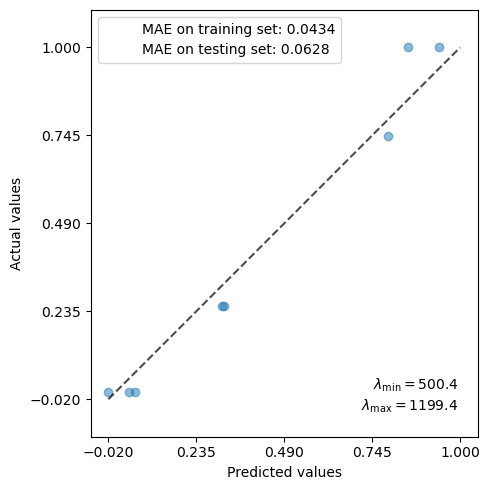

xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 1199.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]


In [30]:
c_viable_models, c_bestmodel_container, c_y_best, c_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='cellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)


In [31]:
#best = bestmodel_container[0]
#print(bestmodel_container[2])

In [32]:
import time

Running analysis splitting interval into 1 windows.
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
we have a new best model!
current score: 0.11722174888126642
Running analysis splitting interval into 5 windows.
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 1199.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
we have a new best model!
current score: 0.08119255467277066
xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
we have a new best model!
current score: 0.06186634333535074
xbounds is not a DataArray or Dataset.
xbounds: [1900.7801 2599.7801]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False Fals

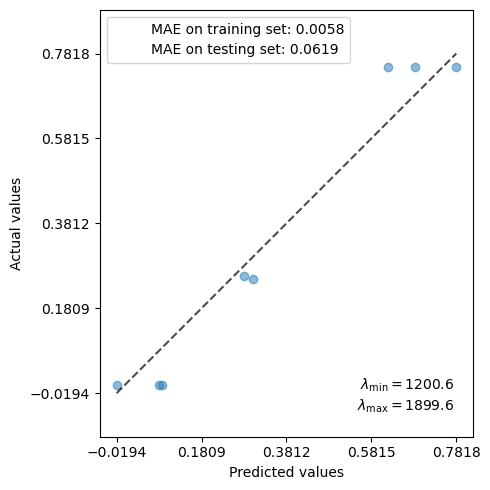

xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
-9.290301084518433


In [33]:
start = time.time()
h_viable_models, h_bestmodel_container, h_y_best, h_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='hemicellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(start-end)

In [34]:
#bestmodel_container

Running analysis splitting interval into 1 windows.
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
we have a new best model!
current score: 0.11722174888126642
Running analysis splitting interval into 5 windows.
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 1199.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
we have a new best model!
current score: 0.08119255467277066
xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
we have a new best model!
current score: 0.06186634333535074
xbounds is not a DataArray or Dataset.
xbounds: [1900.7801 2599.7801]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False Fals

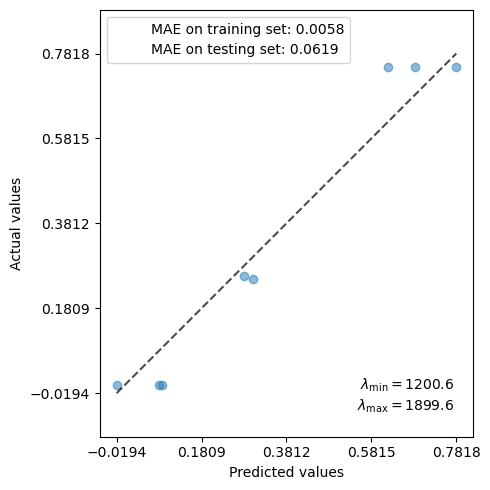

xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
9.161251068115234


In [35]:
start = time.time()
l_viable_models, l_bestmodel_container, l_y_best, l_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='hemicellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(end-start)

In [68]:
# l_bestmodel_container
l_X_best[0]

array([ 2.6540e-04,  2.5077e-04,  2.3241e-04, ..., -5.0690e-05,
        7.2700e-06,  6.2550e-05])

In [72]:
# Read and clean the new data
new_file_path = os.path.join(os.sep, cwd, 'T1-1.csv')
new_data = pd.read_csv(new_file_path, 
#                        names=['wavenumber', 'absorbance'], 
                       header=0,
                       dtype='float') #
print(new_data)
window = l_bestmodel_container[1]
print(window)
new_data = new_data.where(new_data['wavenumber'] > window[0]).where(new_data['wavenumber'] < window[1])
new_data = new_data.dropna()
print(new_data)
new_data = np.array(new_data['absorbance']).reshape(1,-1)

lignin_predictor = l_bestmodel_container[0]
prediction = lignin_predictor.predict(new_data_a)

print("Predicted Composition for T1-1 (cellulose):", prediction)


      wavenumber  absorbance
0          400.0      0.0000
1          400.0      0.1550
2          401.0      0.1530
3          401.0      0.1500
4          402.0      0.1440
...          ...         ...
7464      4000.0      0.0117
7465      4000.0      0.0116
7466      4000.0      0.0116
7467      4000.0      0.0116
7468      4000.0      0.0117

[7469 rows x 2 columns]
[1200.60865 1899.60865]
      wavenumber  absorbance
1671      1210.0      0.0445
1672      1210.0      0.0445
1673      1210.0      0.0444
1674      1210.0      0.0443
1675      1210.0      0.0442
...          ...         ...
3097      1890.0      0.0149
3098      1890.0      0.0150
3099      1890.0      0.0151
3100      1890.0      0.0152
3101      1890.0      0.0153

[1431 rows x 2 columns]


ValueError: X has 1431 features, but PLSRegression is expecting 1450 features as input.